In [137]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [138]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [139]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [140]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [141]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [142]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [143]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [144]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [145]:
# Find the most recent date in the data set.

In [163]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
Last_Year_Observation = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Last_Year_Observation



('2017-08-23')

In [164]:
# Calculate the date one year from the last date in data set.
oneyear_prior = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(oneyear_prior)

2016-08-23


In [165]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > oneyear_prior).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


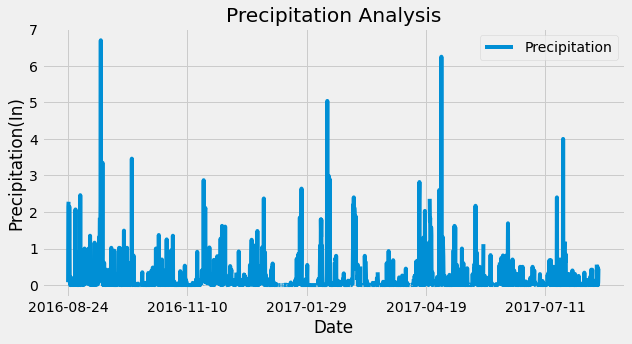

In [166]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(9,5))
plt.title('Precipitation Analysis')
plt.xlabel('Date')
plt.ylabel('Precipitation(In)')
plt.tight_layout()
plt.savefig('Precipitation.png')

In [167]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [168]:
# Design a query to calculate the total number stations in the dataset
station_numbers = session.query(Measurement).group_by(Measurement.station).count()
station_numbers

9

In [169]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

#Results below
#Column 1 "USXXXXX" is Weather station
#Column 2 "XXXX" is most rows/views

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [170]:
popular_station = active_stations[0][0]    
popular_station

'USC00519281'

In [171]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
min_max_avg

[(54.0, 85.0, 71.66378066378067)]

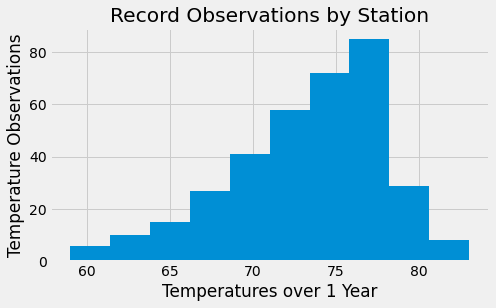

In [172]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearly_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > oneyear_prior).\
    order_by(Measurement.date).all()

fig2 = plt.figure(figsize=(7,4))
plt.grid(True)
oneyeartemp_df = pd.DataFrame(temperature_intel)
plt.hist(oneyeartemp['tobs'])
bin_size = 12
plt.xlabel("Temperatures over 1 Year")
plt.ylabel("Temperature Observations")
plt.title("Record Observations by Station")
plt.savefig('Temperatures Observation over 1 Year')
plt.show()

# Close session

In [173]:
# Close Session
session.close()

In [174]:
#Step 2 - Climate App
#Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
#Use Flask to create your routes.
app = Flask(__name__)

In [175]:
#List all routes that are available.
@app.route("/")
def welcome():

    return (
        f"Available Routes for climate analysis!<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start<br/>"
        f"/api/v1.0/start/end"
    )

In [176]:
#Convert the query results to a dictionary using date as the key and prcp as the value.
@app.route("/api/v1.0/precipitation")
def precipitation():

    #Find last date in database
    Last_Year_Observation = dt.date(2017, 8, 23) - dt.timedelta(days=7*52)

    Last_Year_Observation

    # Query all passengers
    results = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > Last_Year_Observation).all()
    
    # Create a dictionary from the row data and append to a list of all_tobs
    all_tobs = []

    for date_ob in results:
        all_tobs_dict = {}
        all_tobs_dict["Date"] = date_ob.date
        all_tobs_dict["Temperature"] = date_ob.tobs

        all_tobs.append(all_tobs_dict)
    
    # Jsonify all_tobs
    return jsonify(all_tobs)

In [177]:
#Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stationName():
    # Query all station names
    stationName_results = session.query(Station.station).all()

    # Convert list of tuples into normal list
    stationName_list = list(np.ravel(stationName_results))

    # Jsonify all_tobs
    return jsonify(stationName_list)

In [178]:
#Query the dates and temperature observations of the most active station for the last year of data.
#Return a JSON list of temperature observations (TOBS) for the previous year.
@app.route("/api/v1.0/tobs")
def tobs():
    #Find last date in database
    Last_Year_Observation = dt.date(2017, 8, 23) - dt.timedelta(days=7*52)

    Last_Year_Observation

    # Query temp observations
    tobs_results = session.query(Measurement.tobs).filter(Measurement.date > Last_Year_Observation).all()

    # Convert list of tuples into normal list
    tobs_list = list(np.ravel(tobs_results))

    # Jsonify all_tobs
    return jsonify(tobs_list)

In [179]:
#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.
@app.route("/api/v1.0/<startdate>")
def start_date(startdate):
    #Parse the date 
    St_Date = dt.datetime.strptime(startdate,"%Y-%m-%d")

    # Calculate summary stats
    summary_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.round(func.avg(Measurement.tobs))).\
    filter(Measurement.date >= St_Date).all()

    summary = list(np.ravel(summary_stats))

    # Jsonify summary
    return jsonify(summary)

In [181]:
#inclusion of an end date
@app.route("/api/v1.0/<start>/<end>")

def start_end_date(start, end):
    
    calc_temp = calc_temps(start, end)
    ta_temp= list(np.ravel(calc_temp))

    tmin = ta_temp[0]
    tmax = ta_temp[2]
    temp_avg = ta_temp[1]
    temp_dict = { 'Minimum temperature': tmin, 'Maximum temperature': tmax, 'Avg temperature': temp_avg}

    return jsonify(temp_dict)
    



if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1